# Twitter Sentiment Classification: Positive vs. Negative

### Import Libraries

In [13]:
# Natural Language Libraries
import nltk
from nltk.corpus import opinion_lexicon
# Data Handling
import pandas as pd

import json
from joblib import load

import sys
import os

# Add the src directory to Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), 'final_logistic'))
sys.path.insert(0, project_root)

# Custom Modules
from text_processing.pre_processing import *
from features.feature_extraction import *
from glove.glove_controller import *
from evaluation import *

### Constants and Supplementary Data
#### Set your GloVe model's path here (200D)

In [14]:
# Random Seed
RANDOM_STATE = 123

# Positive and Negative words lexicon
positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

# Sarcasm Classifier Load
sarcasm_model = load("../data/sarcasm_model.pkl")
sarcasm_vec = load("../data/dict_vectorizer.pkl")

# Load profanity list
with open('../data/profanity.txt', 'r') as f:
    profanity_words = [s.strip() for s in f.readlines()]

# Load slang list
with open('../data/slang.txt', 'r') as f:
    slang_words = [s.strip() for s in f.readlines()]

# Set punctuation list
punct_list = ['!','#','@']

# Load emoji sentiment
with open("../data/emoji_polarity.json", "r", encoding="utf-8") as f:
    emoji_json = json.load(f)

# Load emoticon sentiment
with open("../data/emoticon_polarity.json", "r", encoding="utf-8") as f:
    emoticon_json = json.load(f)
combined_sentiment = {**emoji_json, **emoticon_json}

# Define GloVe variables
glove_path = r"C:\Users\eggle\Downloads\glove.twitter.27B\glove.twitter.27B.200d.txt"
EMBED_DIM = 200 

### Load Datasets

#### Set your Dataset path here

In [15]:
import pandas as pd
df_test  = pd.read_csv('../data/twitter_sentiment_test.csv')

### Load Logistic Regression Model

In [16]:
# Load from final_logistic/models/sentiment_sgd_classifier.pkl
with open('final_logistic/models/sentiment_sgd_classifier.pkl', 'rb') as file:
    final_model = pickle.load(file)

### Apply preprocessing to Dataset

In [17]:
# Apply preprocessing to the datasets
clean_tokens_test = [preprocessing_text(t) for t in df_test['text']]
clean_text_test = [' '.join(tokens) for tokens in clean_tokens_test]

### Feature Extraction

In [18]:
# Define Custom functions
feature_functions = [
    lambda text: count_specified_punctuations(text, punct_list),
    lambda text: count_profanity_words(text, profanity_words),
    lambda text: count_slang_words(text, slang_words), 
    count_all_capital_tokens, 
    count_not,
    count_sad_emoticons,
    count_happy_emoticons,
    count_elongated_words,
    lambda text: count_positive_words(text, positive_words),
    lambda text: count_negative_words(text, negative_words),
    uppercase_ratio,
    count_pos_tags,
    count_named_entities,
    lambda text: get_sentiment_and_subjectivity(text, combined_sentiment),
    lambda text: predict_sarcasm(text, sarcasm_vec, sarcasm_model),
    tweet_word_count,
    tweet_avg_word_length
]

# Load GloVe model
glove_vectors = load_glove(glove_path, EMBED_DIM, use_cache=True, pickle_path='final_logistic/glove/glove.pkl')

Loading GloVe from cache: final_logistic\glove\glove.pkl
Loaded 1193514 word vectors from cache


In [19]:
# Create glove feature matrices
glove_test  = np.vstack([tweet_to_glove_vector(t, glove_vectors, EMBED_DIM) for t in tqdm(clean_text_test, desc="Embedding test")])
glove_test  = pd.DataFrame(glove_test,  columns=[f"glv_{i}" for i in range(EMBED_DIM)])

Embedding test: 100%|██████████| 6347/6347 [00:00<00:00, 99526.50it/s]


#### Concatenate all features together (GloVe + Custom Features)

In [20]:
X_test  = df_test[['text']].copy()

# Extract Custom Features
for func in tqdm(feature_functions, desc="Computing custom features"):
    results = X_test['text'].apply(lambda x: func(str(x))).tolist()
    X_test = pd.concat([X_test, pd.DataFrame(results)], axis=1)

# Drop column name
X_test_custom  = X_test.drop(columns=['text'])

# Concat Custom Features with GloVE embeddings
X_test_final  = pd.concat([glove_test.reset_index(drop=True),  X_test_custom.reset_index(drop=True)], axis=1)

X_test_final.columns  = X_test_final.columns.astype(str)
y_test  = df_test['label']

X_test_final.head(5)

Computing custom features: 100%|██████████| 17/17 [01:01<00:00,  3.62s/it]


,glv_0,glv_1,glv_2,glv_3,glv_4,glv_5,glv_6,glv_7,glv_8,glv_9,...,num_MISC_ratio,num_mentions_ratio,num_hashtags_ratio,multiple_entities,positive_sentiment,negative_sentiment,subjectivity,sarcasm_score,word_count,avg_word_length
0,0.237963,0.379498,-0.104235,0.081532,-0.113407,0.179593,0.928997,0.010397,0.072431,-0.000586,...,0.058824,0.058824,0.117647,1,0.000000,0.0,1.00,0.928804,14,4.928571
1,0.015589,-0.017970,-0.211056,-0.058260,-0.178798,0.103204,0.173257,0.118210,-0.226523,-0.064506,...,0.206897,0.034483,0.000000,1,0.000000,0.0,0.00,0.000010,22,5.090909
2,0.192015,0.345840,-0.034767,-0.014350,0.401737,0.278255,0.420938,-0.318027,-0.101780,-0.006929,...,0.222222,0.000000,0.111111,1,0.000000,0.0,1.00,0.928804,7,7.571429
3,0.129217,0.132057,-0.055793,-0.136512,0.026855,0.124944,0.304527,0.002493,0.245285,0.221887,...,0.052632,0.315789,0.000000,1,0.233333,0.0,0.50,0.499048,18,4.777778
4,-0.002853,-0.508862,0.260693,0.169121,-0.008495,0.175135,0.708770,-0.206418,-0.271168,-0.355350,...,0.125000,0.000000,0.250000,1,0.578125,0.0,0.75,0.996339,6,6.833333


### Train and Evaluate Logistic Regression


=== Model Evaluation ===
Accuracy: 0.8961714195682999
              precision    recall  f1-score   support

    negative       0.90      0.94      0.92      3972
    positive       0.89      0.83      0.86      2375

    accuracy                           0.90      6347
   macro avg       0.89      0.88      0.89      6347
weighted avg       0.90      0.90      0.90      6347



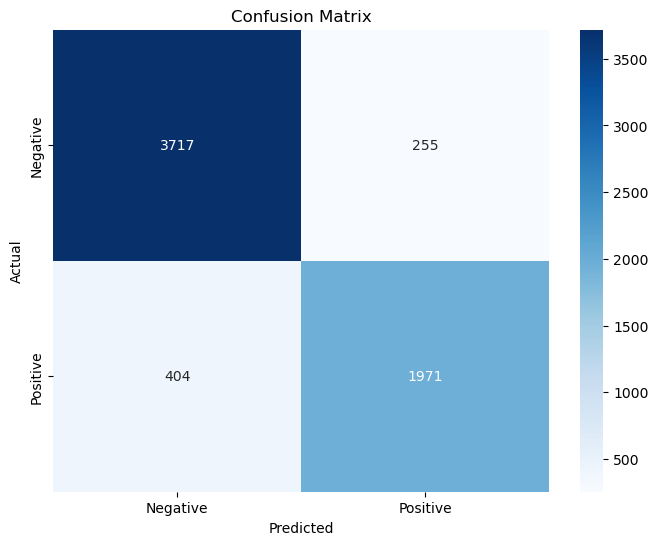

In [21]:
# Get predictions
y_pred = final_model.predict(X_test_final)

# Print report
evaluate_model(y_test, y_pred)

# Generate confusion matrix
plot_confusion_matrix(y_test, y_pred)